In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import spilu
from scipy.sparse.linalg import gmres
from math import *
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from numpy.linalg import cond
from scipy.sparse.linalg import spsolve
from numpy.linalg import solve, norm
from numpy.random import rand
from scipy import sparse
from scipy.sparse import coo_matrix, linalg as sla
from scipy.linalg import qr, solve_triangular
from scipy.special import factorial
from scipy.ndimage import convolve
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import cProfile
import pstats
import io

#Funcion para knn
El algoritmo de vecinos mas cercanos se usa con el fin de obtener la distancia entre un punto y su vecino mas cercano, de esta forma luego puedo filtrar por distancia

In [2]:
def knn(M2):
    coordenadas_raw = M2['p'].flatten()
    clase = M2['v'].flatten()

    # Extracción y conversión desde array estructurado
    coordenadas = np.column_stack((coordenadas_raw['x'], coordenadas_raw['y'])).astype(np.float32)

    # Filtrar puntos de clase 1
    coordenadas_objetivo = coordenadas[clase == 1]

    # Modelo de vecinos más cercanos
    modelo = NearestNeighbors(n_neighbors=1, n_jobs=-1)
    modelo.fit(coordenadas_objetivo)

    distancias, indices = modelo.kneighbors(coordenadas)
    vecinos = coordenadas_objetivo[indices]

    return distancias, clase

#Generacion de la geometria

In [3]:
alpha, etha, Reli, Fr, veces, pot, e, dt, frec, b, no, nc, Ip, lamb = 1, 1, 250, 5, 1, 15, 1, 0.001, 50, 1, 5*10**5, 10**13, 9.6, 60*(10**(-9))
expon=5
const = b * no / nc
cuadrado=(alpha*((10)**(-expon))) #Tamaño real de la grilla en discretizacion uniforme
'identificacion de la matriz M2: '
'La matriz M2 guarda la geometria del sistema donde posee valores numericos para representar las distintas partes de ella de la siguiente forma: '
'1: Punta sometida a Alta Tensión'
'0: Material Aislante'
'2: Placa aterrizada a tierra (V=0)'
'9: Árbol eléctrico (En esta simulación en particular posee el mismo potencial de la punta, por lo que es un árbol conductor)'
###################################################################################
################# Construccion de geometria #######################################
###################################################################################
#esta parte se realiza una sola vez, se escribe un archivo de texto con la geometria inicial para luego ser pasado a la matriz de geometria M2

for tt in range(1):
    b=open('tam3case'+str(tt)+'.txt','w')
    tama=int((10**(-3))/(cuadrado))
    div=2
    pal=''
    for j in range(tama):
        for i in range(2*tama):
            a=((0.06*10**(-3))-cuadrado*j)*tan(pi/8)
            if j<tama-3-div:
                if i*cuadrado>((tama*cuadrado)-a) and i*cuadrado<((tama*cuadrado)+a) and 2*a>=0.000006:
                    b.write('1 ')
                    tamapunta=j+1
                else:
                    b.write('0 ')
            elif j==tama-3-div: #genero la rugosidad aleatoria
                if i%div==0 and i!=2*tama:
                    r=random.choice((0,2))
                    b.write((str(r)+' ')*div)
                    pal=pal+(str(r)+' ')*div
            elif j>tama-3-div and j<=tama-4 :
                if i==0:
                    b.write(pal)
            elif j>tama-4:
                b.write('2 ')
        b.write('\n')
    b.close()
totaldist = tama - tamapunta - 3 / div
delta = alpha * 10**(-expon)
tx, ty = int(0.002 / delta), int(0.001 / delta)
dt = np.dtype([('v', float), ('p', [('x', int), ('y', int)])])
M2 = np.zeros((ty, tx), dtype=dt)
matriz_danno = np.zeros((ty, tx))
with open('tam3case0.txt') as a:
    for contfila, linea in enumerate(a):
        M2['v'][contfila, :len(linea.strip().split())] = list(map(int, linea.strip().split()))

#Diferencias finitas generalizadas

In [4]:

start = time.time()
t, tiempo, inf, u = 0, [], [], [1] * 4
lar = len(u) + 1

###################################################################################
############################ condiciones de borde #################################
###################################################################################

x_coords, y_coords = np.meshgrid(range(M2.shape[0]), range(M2.shape[1]), indexing='ij')
xx,yy=x_coords,y_coords
xx,yy=xx.ravel(),yy.ravel()
M2['p']['x'], M2['p']['y'] = x_coords, y_coords
values = {1: pot, 9: pot, 2: 0, 0: 0, -1:0,-2:0,-3:0,-4:0} #diccionario con las condiciones de dirichlet


positions = {k: np.where(M2['v'].ravel() == k) for k in values}
n = M2['v'].size
sistema, B = np.zeros((n, n)), np.zeros(n)

#condiciones de dirichlet
for k, v in values.items():
    sistema[positions[k], positions[k]], B[positions[k]] = 1, v

#########################################################################################################
################################ Calculo del problema de minimos cuadrados ##############################
#########################################################################################################

xx = xx.astype(np.float32)
yy = yy.astype(np.float32)

vec=np.sqrt((xx[positions[0]][:,None]-xx)**2 + (yy[positions[0]][:,None]-yy)**2) #Mapeo la distancia entre los puntos de interes (aislante) y todos los demas puntos
#separo entre distancia en x e y
vec_x=-xx[positions[0]][:,None]+xx
vec_y=-yy[positions[0]][:,None]+yy

#obtengo para cada uno de mis puntos, los vecinos segun un radio de influencia
vec_wh=np.where((np.abs(vec)<=2) & (np.abs(vec)>0.1))
puntos_ordenados,vecinos_ordenados=vec_wh[0],vec_wh[1]
indices_unicos, posiciones = np.unique(puntos_ordenados, return_index=True)
vecinos_separados = np.split(vecinos_ordenados, posiciones[1:])
estructura_vecinos = dict(zip(indices_unicos, vecinos_separados)) #me indica los vecinos de punto a los demas puntos en un diccionario
indices_unicos = np.array(list(estructura_vecinos.keys()))
M2['v'][M2['v'] == 2] = -5
sistema_Ex=np.copy(sistema)
sistema_Ey=np.copy(sistema)
#Condiciones de Neumman
##Caracterizo los bordes de manera distinta al resto de los puntos (con -1,-2) de modo de aplicar las condiciones de neumman en tales bordes
M2['v'][:,0]=np.where(M2['v'][:,0]==0,-1,M2['v'][:,0])
M2['v'][0,:]=np.where(M2['v'][0,:]==0,-2,M2['v'][0,:])
M2['v'][:,-1]=np.where(M2['v'][:,-1]==0,-1,M2['v'][:,-1])
M2['v'][-1,:]=np.where(M2['v'][-1,:]==0,-2,M2['v'][-1,:])
positions_neumann1=np.where(M2['v'].ravel() == -1)[0]
positions_neumann2=np.where(M2['v'].ravel() == -2)[0]
#Algoritmo de minimos cuadrados para el problema de diferencias finitas generalizadas
for k in indices_unicos: #itero para cada vecino
    vecinos_k=len(estructura_vecinos[k])
    largo_com=len(estructura_vecinos[k][estructura_vecinos[k]<k])
    matriz_resultados = np.array([vec_x[k][estructura_vecinos[k]],vec_y[k][estructura_vecinos[k]],0.5*(vec_x[k][estructura_vecinos[k]])**2,0.5*(vec_y[k][estructura_vecinos[k]])**2]) #Matriz A del problema de minimos cuadrados
    matriz_f=np.zeros((vecinos_k,vecinos_k+1))
    pme=len(np.where(estructura_vecinos[k]<k)[0])
    matriz_f[:,pme]=-1
    matriz_f[:,:pme]=np.eye(vecinos_k)[:,:pme]
    matriz_f[:,pme+1:]=np.eye(vecinos_k)[:,pme:]
    Q,R=qr(matriz_resultados.T,mode='economic')
    C=Q.T@matriz_f
    Af=solve_triangular(R, C, lower=False)
    if positions[0][0][k] in positions_neumann1:
      sistema[positions[0][0][k],estructura_vecinos[k][:pme]]=Af[1][:pme]
      sistema[positions[0][0][k],positions[0][0][k]]=Af[1][pme]
      sistema[positions[0][0][k],estructura_vecinos[k][pme:]]=Af[1][pme+1:]
    elif positions[0][0][k] in positions_neumann2:
      sistema[positions[0][0][k],estructura_vecinos[k][:pme]]=Af[0][:pme]
      sistema[positions[0][0][k],positions[0][0][k]]=Af[0][pme]
      sistema[positions[0][0][k],estructura_vecinos[k][pme:]]=Af[0][pme+1:]
    else:
      sistema[positions[0][0][k],estructura_vecinos[k][:pme]]=Af[2][:pme]+Af[3][:pme]
      sistema[positions[0][0][k],positions[0][0][k]]=Af[2][pme]+Af[3][pme]
      sistema[positions[0][0][k],estructura_vecinos[k][pme:]]=Af[2][pme+1:]+Af[3][pme+1:]
    sistema_Ex[positions[0][0][k],estructura_vecinos[k][:pme]]=Af[0][:pme]
    sistema_Ex[positions[0][0][k],positions[0][0][k]]=Af[0][pme]
    sistema_Ex[positions[0][0][k],estructura_vecinos[k][pme:]]=Af[0][pme+1:]
    sistema_Ey[positions[0][0][k],estructura_vecinos[k][:pme]]=Af[1][:pme]
    sistema_Ey[positions[0][0][k],positions[0][0][k]]=Af[1][pme]
    sistema_Ey[positions[0][0][k],estructura_vecinos[k][pme:]]=Af[1][pme+1:]
end = time.time()
print(f"Tiempo de ejecución A: {end - start:.4f} segundos")

#resolucion del sistema de ecuaciones para el paso 1, por medio de matrices Sparse y GMRES
sistema_sparse = csr_matrix(sistema)
V, info = gmres(sistema_sparse, B, atol=1e-5, maxiter=500)
V_2d = V.reshape(ty, tx)


###Observación: Otra ventaja de usar diferencias finitas generalizadas es que se puede obtener el valor de las derivadas de primer orden del potencial electrico y por ende la magnitud del campo electrico en las direcciones X e Y sin la necesidad de pasar por np.grad (me ahorro el costo computacional de calcular el gradiente)
### Idea, como en el estado del arte se ocupan grillas cuadradas y los puntos de halton o la distribucion de puntos en general no es equiespaciada, se podria generar una grilla basada en quadtrees de manera que quede pseudo-equiespaciada

Tiempo de ejecución A: 15.5472 segundos


#Modelo de crecimiento del árbol eléctrico

In [5]:
##########################################################################################################
#################################### MODELO DE CRECIMIENTO ###############################################
##########################################################################################################

radio=2
def arbol(V_2d, delta, M2,sistema,B):
    'aprovecho diferencias finitas generalizadas para obtener el potencial, puesto que tambien me entrega la primera derivada'
    Ex=sistema_Ex@V
    Ey=sistema_Ey@V
    E_magnitud = 0.01*np.sqrt(Ex**2 + Ey**2) #0.01 transformacion de unidades para pasar a kV/cm
    distancias,clase=knn(M2)
    index_=np.where(distancias<radio)[0] #posibles vecinos
    index_=index_[index_>800]
    id_e=np.where(clase[index_]==0)
    index_E=index_[id_e] #ahora los filtro para que solo participen los que son aislantes
    flat = E_magnitud[index_E]
    #modelo de crecimiento basado en probabilidades
    probabilidades = (flat**2) / (flat**2).sum()
    idx = np.random.choice(len(flat), p=probabilidades) #idx es la posicion de la celda en el sistema de ecuaciones, esto se usa para identificarla en el sistema
    idx=index_E[idx]
    #la celda escogida se transforma en arbol por lo que ahora su potencial es conocido
    #sistema=sistema.tolil()
    sistema[idx,:]=0
    sistema[idx,idx]=1
    #sistema=sistema.tocsc()
    i, j = np.unravel_index(idx, M2['v'].shape)
    B[idx]=15
    M2['v'][i][j]=1
    return (M2['v'],sistema,B) #el algoritmo entrega como salida la geometria y el sistema de ecuaciones nuevo
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Asumiendo que tx, ty ya están definidos como dimensiones de V_2d
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

# Prealocamos los arrays para potencial y geometría

n_times=500 ##Numero de iteraciones
mapas_V_2d = np.zeros((n_times, ty, tx))
geometrias = np.zeros((n_times, *M2['v'].shape))  # Guardamos la geometría (árbol)

t = 0
pr = cProfile.Profile()
pr.enable()

sistema_sparse = csr_matrix(sistema)

for i in range(n_times):
    start = time.time()
    M2['v'], sistema_sparse, B = arbol(V_2d, delta, M2, sistema_sparse, B)

    if i % 50 == 0: #se usa un precondicionador M basado en ILU de la matriz del sistema, esta se rearma cada 50 iteraciones
        try:
            ilu = spilu(sistema_sparse)
            M = LinearOperator(sistema_sparse.shape, ilu.solve)
        except RuntimeError as e:
            print(f"Fallo en la factorización ILU: {e}")
            M = None

    V, info = gmres(sistema_sparse, B, M=M, x0=V, atol=1e-5, maxiter=100)

    if info == 0:
        print(f"Iteración {i}: Convergió correctamente.")
    elif info > 0:
        print(f"Iteración {i}: No convergió tras {info} iteraciones.")
    else:
        print(f"Iteración {i}: Error interno.")

    V_2d = V.reshape(ty, tx)
    mapas_V_2d[i] = V_2d
    geometrias[i] = M2['v']  # Guardamos geometría actual

    end = time.time()
    t += end - start
    print(f"Tiempo de ejecución: {end - start:.4f} segundos")

pr.disable()
s = io.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
ps.print_stats(40)
print(s.getvalue())

# Función para visualizar mapa de calor y geometría
def plot_iteracion(iteracion):
    # Mapa de calor del potencial
    ux = range(mapas_V_2d.shape[1] + 1)
    uy = range(mapas_V_2d.shape[2] + 1)
    xx_2d, yy_2d = np.meshgrid(ux, uy, indexing='ij')

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    pcm = axs[0].pcolormesh(
        np.max(uy) - yy_2d,
        np.max(ux) - xx_2d,
        mapas_V_2d[iteracion],
        cmap='inferno'
    )
    axs[0].set_title(f"Iteración {iteracion} - Potencial", fontsize=16)
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")
    axs[0].set_aspect('equal')

    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(pcm, cax=cax)

    # Geometría
    data_volteada = np.fliplr(geometrias[iteracion])
    cmap = mcolors.ListedColormap(['black', 'blue', 'green', 'yellow'])
    bounds = [-5, 0, 1, 9]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    axs[1].imshow(data_volteada, cmap=cmap, norm=norm, interpolation='nearest')
    axs[1].set_title(f"Iteración {iteracion} - Geometría", fontsize=16)
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("y")

    plt.tight_layout()
    plt.show()



/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
<ipython-input-5-e9ab6229a877>:57: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spilu(sistema_sparse)


Iteración 0: Convergió correctamente.
Tiempo de ejecución: 0.9548 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 1: Convergió correctamente.
Tiempo de ejecución: 0.5789 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 2: Convergió correctamente.
Tiempo de ejecución: 0.6080 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 3: Convergió correctamente.
Tiempo de ejecución: 0.6258 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 4: Convergió correctamente.
Tiempo de ejecución: 0.6578 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 5: Convergió correctamente.
Tiempo de ejecución: 0.6366 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 6: Convergió correctamente.
Tiempo de ejecución: 0.7889 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 7: Convergió correctamente.
Tiempo de ejecución: 1.7654 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 8: Convergió correctamente.
Tiempo de ejecución: 0.9984 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 9: Convergió correctamente.
Tiempo de ejecución: 1.0573 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 10: Convergió correctamente.
Tiempo de ejecución: 0.7711 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 11: Convergió correctamente.
Tiempo de ejecución: 0.9560 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 12: Convergió correctamente.
Tiempo de ejecución: 0.7527 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 13: Convergió correctamente.
Tiempo de ejecución: 0.9862 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 14: Convergió correctamente.
Tiempo de ejecución: 1.0809 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 15: Convergió correctamente.
Tiempo de ejecución: 1.0465 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 16: Convergió correctamente.
Tiempo de ejecución: 1.0133 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 17: Convergió correctamente.
Tiempo de ejecución: 1.0559 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 18: Convergió correctamente.
Tiempo de ejecución: 1.8893 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 19: Convergió correctamente.
Tiempo de ejecución: 1.1757 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 20: Convergió correctamente.
Tiempo de ejecución: 1.1041 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 21: Convergió correctamente.
Tiempo de ejecución: 0.7921 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 22: Convergió correctamente.
Tiempo de ejecución: 0.9728 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 23: Convergió correctamente.
Tiempo de ejecución: 0.9395 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 24: Convergió correctamente.
Tiempo de ejecución: 1.3529 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 25: Convergió correctamente.
Tiempo de ejecución: 1.3689 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 26: Convergió correctamente.
Tiempo de ejecución: 1.1460 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 27: Convergió correctamente.
Tiempo de ejecución: 1.0713 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 28: Convergió correctamente.
Tiempo de ejecución: 2.6292 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 29: Convergió correctamente.
Tiempo de ejecución: 1.2250 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 30: Convergió correctamente.
Tiempo de ejecución: 1.4509 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 31: Convergió correctamente.
Tiempo de ejecución: 0.8904 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 32: Convergió correctamente.
Tiempo de ejecución: 0.9265 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 33: Convergió correctamente.
Tiempo de ejecución: 0.9938 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 34: Convergió correctamente.
Tiempo de ejecución: 0.7367 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 35: Convergió correctamente.
Tiempo de ejecución: 0.8528 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 36: Convergió correctamente.
Tiempo de ejecución: 1.2829 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 37: Convergió correctamente.
Tiempo de ejecución: 2.3341 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 38: Convergió correctamente.
Tiempo de ejecución: 1.3596 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 39: Convergió correctamente.
Tiempo de ejecución: 1.2866 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 40: Convergió correctamente.
Tiempo de ejecución: 1.1107 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 41: Convergió correctamente.
Tiempo de ejecución: 1.2665 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 42: Convergió correctamente.
Tiempo de ejecución: 0.9969 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 43: Convergió correctamente.
Tiempo de ejecución: 1.0497 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 44: Convergió correctamente.
Tiempo de ejecución: 1.2802 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 45: Convergió correctamente.
Tiempo de ejecución: 1.5293 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 46: Convergió correctamente.
Tiempo de ejecución: 2.2874 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 47: Convergió correctamente.
Tiempo de ejecución: 1.4660 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 48: Convergió correctamente.
Tiempo de ejecución: 0.7344 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 49: Convergió correctamente.
Tiempo de ejecución: 1.7240 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
<ipython-input-5-e9ab6229a877>:57: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spilu(sistema_sparse)


Iteración 50: Convergió correctamente.
Tiempo de ejecución: 1.8670 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 51: Convergió correctamente.
Tiempo de ejecución: 0.3218 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 52: Convergió correctamente.
Tiempo de ejecución: 0.3280 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 53: Convergió correctamente.
Tiempo de ejecución: 0.3706 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 54: Convergió correctamente.
Tiempo de ejecución: 0.3484 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 55: Convergió correctamente.
Tiempo de ejecución: 0.3751 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 56: Convergió correctamente.
Tiempo de ejecución: 0.3698 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 57: Convergió correctamente.
Tiempo de ejecución: 0.3899 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 58: Convergió correctamente.
Tiempo de ejecución: 0.3592 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 59: Convergió correctamente.
Tiempo de ejecución: 0.4014 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 60: Convergió correctamente.
Tiempo de ejecución: 0.3648 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 61: Convergió correctamente.
Tiempo de ejecución: 0.6458 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 62: Convergió correctamente.
Tiempo de ejecución: 0.5432 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 63: Convergió correctamente.
Tiempo de ejecución: 0.4822 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 64: Convergió correctamente.
Tiempo de ejecución: 0.4143 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 65: Convergió correctamente.
Tiempo de ejecución: 0.3772 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 66: Convergió correctamente.
Tiempo de ejecución: 0.3799 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 67: Convergió correctamente.
Tiempo de ejecución: 0.3786 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 68: Convergió correctamente.
Tiempo de ejecución: 0.3863 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 69: Convergió correctamente.
Tiempo de ejecución: 0.4172 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 70: Convergió correctamente.
Tiempo de ejecución: 0.4158 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 71: Convergió correctamente.
Tiempo de ejecución: 0.3832 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 72: Convergió correctamente.
Tiempo de ejecución: 0.4401 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 73: Convergió correctamente.
Tiempo de ejecución: 0.4509 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 74: Convergió correctamente.
Tiempo de ejecución: 0.4145 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 75: Convergió correctamente.
Tiempo de ejecución: 0.4031 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 76: Convergió correctamente.
Tiempo de ejecución: 0.4254 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 77: Convergió correctamente.
Tiempo de ejecución: 0.4923 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 78: Convergió correctamente.
Tiempo de ejecución: 0.4563 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 79: Convergió correctamente.
Tiempo de ejecución: 0.4795 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 80: Convergió correctamente.
Tiempo de ejecución: 0.4727 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 81: Convergió correctamente.
Tiempo de ejecución: 0.4289 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 82: Convergió correctamente.
Tiempo de ejecución: 0.4701 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 83: Convergió correctamente.
Tiempo de ejecución: 0.4819 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 84: Convergió correctamente.
Tiempo de ejecución: 0.4811 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 85: Convergió correctamente.
Tiempo de ejecución: 0.4851 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 86: Convergió correctamente.
Tiempo de ejecución: 0.4628 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 87: Convergió correctamente.
Tiempo de ejecución: 0.5629 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 88: Convergió correctamente.
Tiempo de ejecución: 1.0799 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 89: Convergió correctamente.
Tiempo de ejecución: 0.5994 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 90: Convergió correctamente.
Tiempo de ejecución: 0.4670 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 91: Convergió correctamente.
Tiempo de ejecución: 0.4672 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 92: Convergió correctamente.
Tiempo de ejecución: 0.4216 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 93: Convergió correctamente.
Tiempo de ejecución: 0.5251 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 94: Convergió correctamente.
Tiempo de ejecución: 0.4595 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 95: Convergió correctamente.
Tiempo de ejecución: 0.5424 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 96: Convergió correctamente.
Tiempo de ejecución: 0.4942 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 97: Convergió correctamente.
Tiempo de ejecución: 0.4930 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 98: Convergió correctamente.
Tiempo de ejecución: 0.5917 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 99: Convergió correctamente.
Tiempo de ejecución: 0.5032 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
<ipython-input-5-e9ab6229a877>:57: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spilu(sistema_sparse)


Iteración 100: Convergió correctamente.
Tiempo de ejecución: 2.2586 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 101: Convergió correctamente.
Tiempo de ejecución: 0.3450 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 102: Convergió correctamente.
Tiempo de ejecución: 0.3775 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 103: Convergió correctamente.
Tiempo de ejecución: 0.3678 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 104: Convergió correctamente.
Tiempo de ejecución: 0.4170 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 105: Convergió correctamente.
Tiempo de ejecución: 0.4203 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 106: Convergió correctamente.
Tiempo de ejecución: 0.3598 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 107: Convergió correctamente.
Tiempo de ejecución: 0.4991 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 108: Convergió correctamente.
Tiempo de ejecución: 0.8039 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 109: Convergió correctamente.
Tiempo de ejecución: 0.6389 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 110: Convergió correctamente.
Tiempo de ejecución: 0.4234 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 111: Convergió correctamente.
Tiempo de ejecución: 0.4021 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 112: Convergió correctamente.
Tiempo de ejecución: 0.4193 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 113: Convergió correctamente.
Tiempo de ejecución: 0.4353 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 114: Convergió correctamente.
Tiempo de ejecución: 0.4193 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 115: Convergió correctamente.
Tiempo de ejecución: 0.3869 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 116: Convergió correctamente.
Tiempo de ejecución: 0.4259 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 117: Convergió correctamente.
Tiempo de ejecución: 0.4252 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 118: Convergió correctamente.
Tiempo de ejecución: 0.4429 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 119: Convergió correctamente.
Tiempo de ejecución: 0.4049 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 120: Convergió correctamente.
Tiempo de ejecución: 0.4075 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 121: Convergió correctamente.
Tiempo de ejecución: 0.4223 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 122: Convergió correctamente.
Tiempo de ejecución: 0.4449 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 123: Convergió correctamente.
Tiempo de ejecución: 0.5025 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 124: Convergió correctamente.
Tiempo de ejecución: 0.4278 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 125: Convergió correctamente.
Tiempo de ejecución: 0.4343 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 126: Convergió correctamente.
Tiempo de ejecución: 0.4073 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 127: Convergió correctamente.
Tiempo de ejecución: 0.3788 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 128: Convergió correctamente.
Tiempo de ejecución: 0.4996 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 129: Convergió correctamente.
Tiempo de ejecución: 0.4820 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 130: Convergió correctamente.
Tiempo de ejecución: 0.4896 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 131: Convergió correctamente.
Tiempo de ejecución: 0.4567 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 132: Convergió correctamente.
Tiempo de ejecución: 0.4373 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 133: Convergió correctamente.
Tiempo de ejecución: 0.6871 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 134: Convergió correctamente.
Tiempo de ejecución: 0.8379 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 135: Convergió correctamente.
Tiempo de ejecución: 0.6669 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 136: Convergió correctamente.
Tiempo de ejecución: 0.4570 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 137: Convergió correctamente.
Tiempo de ejecución: 0.4551 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 138: Convergió correctamente.
Tiempo de ejecución: 0.4746 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 139: Convergió correctamente.
Tiempo de ejecución: 0.4614 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 140: Convergió correctamente.
Tiempo de ejecución: 0.4687 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 141: Convergió correctamente.
Tiempo de ejecución: 0.5004 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 142: Convergió correctamente.
Tiempo de ejecución: 0.5091 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 143: Convergió correctamente.
Tiempo de ejecución: 0.4963 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 144: Convergió correctamente.
Tiempo de ejecución: 0.5058 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 145: Convergió correctamente.
Tiempo de ejecución: 0.4858 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 146: Convergió correctamente.
Tiempo de ejecución: 0.4821 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 147: Convergió correctamente.
Tiempo de ejecución: 0.5763 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 148: Convergió correctamente.
Tiempo de ejecución: 0.5359 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 149: Convergió correctamente.
Tiempo de ejecución: 0.5146 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
<ipython-input-5-e9ab6229a877>:57: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spilu(sistema_sparse)


Iteración 150: Convergió correctamente.
Tiempo de ejecución: 2.2733 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 151: Convergió correctamente.
Tiempo de ejecución: 0.3954 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 152: Convergió correctamente.
Tiempo de ejecución: 0.4096 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 153: Convergió correctamente.
Tiempo de ejecución: 0.5522 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 154: Convergió correctamente.
Tiempo de ejecución: 0.5612 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 155: Convergió correctamente.
Tiempo de ejecución: 0.5796 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 156: Convergió correctamente.
Tiempo de ejecución: 0.4137 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 157: Convergió correctamente.
Tiempo de ejecución: 0.3976 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 158: Convergió correctamente.
Tiempo de ejecución: 0.3902 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 159: Convergió correctamente.
Tiempo de ejecución: 0.3634 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 160: Convergió correctamente.
Tiempo de ejecución: 0.4491 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 161: Convergió correctamente.
Tiempo de ejecución: 0.3944 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 162: Convergió correctamente.
Tiempo de ejecución: 0.4518 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 163: Convergió correctamente.
Tiempo de ejecución: 0.4262 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 164: Convergió correctamente.
Tiempo de ejecución: 0.4106 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 165: Convergió correctamente.
Tiempo de ejecución: 0.4188 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 166: Convergió correctamente.
Tiempo de ejecución: 0.4210 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 167: Convergió correctamente.
Tiempo de ejecución: 0.4571 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 168: Convergió correctamente.
Tiempo de ejecución: 0.4296 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 169: Convergió correctamente.
Tiempo de ejecución: 0.4193 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 170: Convergió correctamente.
Tiempo de ejecución: 0.4541 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 171: Convergió correctamente.
Tiempo de ejecución: 0.4631 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 172: Convergió correctamente.
Tiempo de ejecución: 0.4786 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 173: Convergió correctamente.
Tiempo de ejecución: 0.4493 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 174: Convergió correctamente.
Tiempo de ejecución: 0.5088 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 175: Convergió correctamente.
Tiempo de ejecución: 0.4442 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 176: Convergió correctamente.
Tiempo de ejecución: 0.4700 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 177: Convergió correctamente.
Tiempo de ejecución: 0.4455 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 178: Convergió correctamente.
Tiempo de ejecución: 0.5427 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 179: Convergió correctamente.
Tiempo de ejecución: 0.7986 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 180: Convergió correctamente.
Tiempo de ejecución: 0.6354 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 181: Convergió correctamente.
Tiempo de ejecución: 0.5530 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 182: Convergió correctamente.
Tiempo de ejecución: 0.4873 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 183: Convergió correctamente.
Tiempo de ejecución: 0.4764 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 184: Convergió correctamente.
Tiempo de ejecución: 0.5126 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 185: Convergió correctamente.
Tiempo de ejecución: 0.4855 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 186: Convergió correctamente.
Tiempo de ejecución: 0.4782 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 187: Convergió correctamente.
Tiempo de ejecución: 0.4127 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 188: Convergió correctamente.
Tiempo de ejecución: 0.5576 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 189: Convergió correctamente.
Tiempo de ejecución: 0.5150 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 190: Convergió correctamente.
Tiempo de ejecución: 0.5565 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 191: Convergió correctamente.
Tiempo de ejecución: 0.5287 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 192: Convergió correctamente.
Tiempo de ejecución: 0.5605 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 193: Convergió correctamente.
Tiempo de ejecución: 0.5210 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 194: Convergió correctamente.
Tiempo de ejecución: 0.4989 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 195: Convergió correctamente.
Tiempo de ejecución: 0.5456 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 196: Convergió correctamente.
Tiempo de ejecución: 0.5103 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 197: Convergió correctamente.
Tiempo de ejecución: 0.5539 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 198: Convergió correctamente.
Tiempo de ejecución: 0.5803 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 199: Convergió correctamente.
Tiempo de ejecución: 0.5543 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
<ipython-input-5-e9ab6229a877>:57: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spilu(sistema_sparse)


Iteración 200: Convergió correctamente.
Tiempo de ejecución: 3.1324 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 201: Convergió correctamente.
Tiempo de ejecución: 0.4150 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 202: Convergió correctamente.
Tiempo de ejecución: 0.4206 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 203: Convergió correctamente.
Tiempo de ejecución: 0.4118 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 204: Convergió correctamente.
Tiempo de ejecución: 0.4206 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 205: Convergió correctamente.
Tiempo de ejecución: 0.4360 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 206: Convergió correctamente.
Tiempo de ejecución: 0.4321 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 207: Convergió correctamente.
Tiempo de ejecución: 0.4403 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 208: Convergió correctamente.
Tiempo de ejecución: 0.4703 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 209: Convergió correctamente.
Tiempo de ejecución: 0.4420 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 210: Convergió correctamente.
Tiempo de ejecución: 0.4737 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 211: Convergió correctamente.
Tiempo de ejecución: 0.4288 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 212: Convergió correctamente.
Tiempo de ejecución: 0.4515 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 213: Convergió correctamente.
Tiempo de ejecución: 0.5138 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 214: Convergió correctamente.
Tiempo de ejecución: 0.4011 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 215: Convergió correctamente.
Tiempo de ejecución: 0.4677 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 216: Convergió correctamente.
Tiempo de ejecución: 0.4474 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 217: Convergió correctamente.
Tiempo de ejecución: 0.4499 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 218: Convergió correctamente.
Tiempo de ejecución: 0.4819 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 219: Convergió correctamente.
Tiempo de ejecución: 0.4627 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 220: Convergió correctamente.
Tiempo de ejecución: 0.6973 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 221: Convergió correctamente.
Tiempo de ejecución: 0.6772 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 222: Convergió correctamente.
Tiempo de ejecución: 0.6381 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 223: Convergió correctamente.
Tiempo de ejecución: 0.4536 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 224: Convergió correctamente.
Tiempo de ejecución: 0.4144 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 225: Convergió correctamente.
Tiempo de ejecución: 0.4700 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 226: Convergió correctamente.
Tiempo de ejecución: 0.4933 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 227: Convergió correctamente.
Tiempo de ejecución: 0.4945 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 228: Convergió correctamente.
Tiempo de ejecución: 0.4935 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 229: Convergió correctamente.
Tiempo de ejecución: 0.4788 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 230: Convergió correctamente.
Tiempo de ejecución: 0.5410 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 231: Convergió correctamente.
Tiempo de ejecución: 0.4710 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 232: Convergió correctamente.
Tiempo de ejecución: 0.5535 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 233: Convergió correctamente.
Tiempo de ejecución: 0.4998 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 234: Convergió correctamente.
Tiempo de ejecución: 0.4942 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 235: Convergió correctamente.
Tiempo de ejecución: 0.5142 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 236: Convergió correctamente.
Tiempo de ejecución: 0.5073 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 237: Convergió correctamente.
Tiempo de ejecución: 0.4799 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 238: Convergió correctamente.
Tiempo de ejecución: 0.5538 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 239: Convergió correctamente.
Tiempo de ejecución: 0.5662 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 240: Convergió correctamente.
Tiempo de ejecución: 0.4807 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 241: Convergió correctamente.
Tiempo de ejecución: 0.5477 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 242: Convergió correctamente.
Tiempo de ejecución: 0.5202 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 243: Convergió correctamente.
Tiempo de ejecución: 0.9327 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 244: Convergió correctamente.
Tiempo de ejecución: 0.7431 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 245: Convergió correctamente.
Tiempo de ejecución: 0.4824 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 246: Convergió correctamente.
Tiempo de ejecución: 0.5808 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 247: Convergió correctamente.
Tiempo de ejecución: 0.5548 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 248: Convergió correctamente.
Tiempo de ejecución: 0.5168 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 249: Convergió correctamente.
Tiempo de ejecución: 0.5815 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
<ipython-input-5-e9ab6229a877>:57: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spilu(sistema_sparse)


Iteración 250: Convergió correctamente.
Tiempo de ejecución: 2.6631 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 251: Convergió correctamente.
Tiempo de ejecución: 0.4285 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 252: Convergió correctamente.
Tiempo de ejecución: 0.4125 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 253: Convergió correctamente.
Tiempo de ejecución: 0.4490 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 254: Convergió correctamente.
Tiempo de ejecución: 0.4374 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 255: Convergió correctamente.
Tiempo de ejecución: 0.4357 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 256: Convergió correctamente.
Tiempo de ejecución: 0.4531 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 257: Convergió correctamente.
Tiempo de ejecución: 0.4335 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 258: Convergió correctamente.
Tiempo de ejecución: 0.4480 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 259: Convergió correctamente.
Tiempo de ejecución: 0.4479 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 260: Convergió correctamente.
Tiempo de ejecución: 0.4579 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 261: Convergió correctamente.
Tiempo de ejecución: 0.7004 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 262: Convergió correctamente.
Tiempo de ejecución: 0.6665 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 263: Convergió correctamente.
Tiempo de ejecución: 0.5715 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 264: Convergió correctamente.
Tiempo de ejecución: 0.4745 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 265: Convergió correctamente.
Tiempo de ejecución: 0.4401 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 266: Convergió correctamente.
Tiempo de ejecución: 0.4697 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 267: Convergió correctamente.
Tiempo de ejecución: 0.4628 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 268: Convergió correctamente.
Tiempo de ejecución: 0.4456 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 269: Convergió correctamente.
Tiempo de ejecución: 0.5360 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 270: Convergió correctamente.
Tiempo de ejecución: 0.5409 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 271: Convergió correctamente.
Tiempo de ejecución: 0.4998 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 272: Convergió correctamente.
Tiempo de ejecución: 0.4588 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 273: Convergió correctamente.
Tiempo de ejecución: 0.4638 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 274: Convergió correctamente.
Tiempo de ejecución: 0.5071 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 275: Convergió correctamente.
Tiempo de ejecución: 0.4654 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 276: Convergió correctamente.
Tiempo de ejecución: 0.4746 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 277: Convergió correctamente.
Tiempo de ejecución: 0.5231 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 278: Convergió correctamente.
Tiempo de ejecución: 0.4726 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 279: Convergió correctamente.
Tiempo de ejecución: 0.5721 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 280: Convergió correctamente.
Tiempo de ejecución: 0.5600 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 281: Convergió correctamente.
Tiempo de ejecución: 0.5384 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 282: Convergió correctamente.
Tiempo de ejecución: 0.4629 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 283: Convergió correctamente.
Tiempo de ejecución: 0.5625 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 284: Convergió correctamente.
Tiempo de ejecución: 0.6921 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 285: Convergió correctamente.
Tiempo de ejecución: 0.7499 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 286: Convergió correctamente.
Tiempo de ejecución: 0.6018 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 287: Convergió correctamente.
Tiempo de ejecución: 0.5107 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 288: Convergió correctamente.
Tiempo de ejecución: 0.5208 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 289: Convergió correctamente.
Tiempo de ejecución: 0.5698 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 290: Convergió correctamente.
Tiempo de ejecución: 0.5281 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 291: Convergió correctamente.
Tiempo de ejecución: 0.4901 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 292: Convergió correctamente.
Tiempo de ejecución: 0.4961 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 293: Convergió correctamente.
Tiempo de ejecución: 0.5509 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 294: Convergió correctamente.
Tiempo de ejecución: 0.5287 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 295: Convergió correctamente.
Tiempo de ejecución: 0.4889 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 296: Convergió correctamente.
Tiempo de ejecución: 0.4950 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 297: Convergió correctamente.
Tiempo de ejecución: 0.5844 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 298: Convergió correctamente.
Tiempo de ejecución: 0.5852 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 299: Convergió correctamente.
Tiempo de ejecución: 0.5772 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
<ipython-input-5-e9ab6229a877>:57: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spilu(sistema_sparse)


Iteración 300: Convergió correctamente.
Tiempo de ejecución: 3.5369 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 301: Convergió correctamente.
Tiempo de ejecución: 0.6304 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 302: Convergió correctamente.
Tiempo de ejecución: 0.5340 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 303: Convergió correctamente.
Tiempo de ejecución: 0.4434 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 304: Convergió correctamente.
Tiempo de ejecución: 0.5129 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 305: Convergió correctamente.
Tiempo de ejecución: 0.4446 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 306: Convergió correctamente.
Tiempo de ejecución: 0.4509 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 307: Convergió correctamente.
Tiempo de ejecución: 0.4650 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 308: Convergió correctamente.
Tiempo de ejecución: 0.5313 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 309: Convergió correctamente.
Tiempo de ejecución: 0.4540 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 310: Convergió correctamente.
Tiempo de ejecución: 0.5121 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 311: Convergió correctamente.
Tiempo de ejecución: 0.5093 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 312: Convergió correctamente.
Tiempo de ejecución: 0.3981 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 313: Convergió correctamente.
Tiempo de ejecución: 0.4185 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 314: Convergió correctamente.
Tiempo de ejecución: 0.4485 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 315: Convergió correctamente.
Tiempo de ejecución: 0.4688 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 316: Convergió correctamente.
Tiempo de ejecución: 0.4738 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 317: Convergió correctamente.
Tiempo de ejecución: 0.5297 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 318: Convergió correctamente.
Tiempo de ejecución: 0.5573 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 319: Convergió correctamente.
Tiempo de ejecución: 0.5709 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 320: Convergió correctamente.
Tiempo de ejecución: 0.5262 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 321: Convergió correctamente.
Tiempo de ejecución: 0.5378 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 322: Convergió correctamente.
Tiempo de ejecución: 0.4452 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 323: Convergió correctamente.
Tiempo de ejecución: 0.7287 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 324: Convergió correctamente.
Tiempo de ejecución: 0.8133 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 325: Convergió correctamente.
Tiempo de ejecución: 0.5593 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 326: Convergió correctamente.
Tiempo de ejecución: 0.5598 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 327: Convergió correctamente.
Tiempo de ejecución: 0.5216 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 328: Convergió correctamente.
Tiempo de ejecución: 0.5153 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 329: Convergió correctamente.
Tiempo de ejecución: 0.4635 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 330: Convergió correctamente.
Tiempo de ejecución: 0.5918 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 331: Convergió correctamente.
Tiempo de ejecución: 0.5794 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 332: Convergió correctamente.
Tiempo de ejecución: 0.5962 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 333: Convergió correctamente.
Tiempo de ejecución: 0.6085 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 334: Convergió correctamente.
Tiempo de ejecución: 0.6190 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 335: Convergió correctamente.
Tiempo de ejecución: 0.6504 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 336: Convergió correctamente.
Tiempo de ejecución: 0.5189 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 337: Convergió correctamente.
Tiempo de ejecución: 0.5790 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 338: Convergió correctamente.
Tiempo de ejecución: 0.5167 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 339: Convergió correctamente.
Tiempo de ejecución: 0.5955 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 340: Convergió correctamente.
Tiempo de ejecución: 0.5119 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 341: Convergió correctamente.
Tiempo de ejecución: 0.6210 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 342: Convergió correctamente.
Tiempo de ejecución: 0.5455 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 343: Convergió correctamente.
Tiempo de ejecución: 0.8038 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 344: Convergió correctamente.
Tiempo de ejecución: 0.9351 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 345: Convergió correctamente.
Tiempo de ejecución: 0.5683 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 346: Convergió correctamente.
Tiempo de ejecución: 0.6121 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 347: Convergió correctamente.
Tiempo de ejecución: 0.6059 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 348: Convergió correctamente.
Tiempo de ejecución: 0.6040 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 349: Convergió correctamente.
Tiempo de ejecución: 0.5971 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
<ipython-input-5-e9ab6229a877>:57: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spilu(sistema_sparse)


Iteración 350: Convergió correctamente.
Tiempo de ejecución: 3.5105 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 351: Convergió correctamente.
Tiempo de ejecución: 0.4418 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 352: Convergió correctamente.
Tiempo de ejecución: 0.4276 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 353: Convergió correctamente.
Tiempo de ejecución: 0.4801 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 354: Convergió correctamente.
Tiempo de ejecución: 0.4993 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 355: Convergió correctamente.
Tiempo de ejecución: 0.4736 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 356: Convergió correctamente.
Tiempo de ejecución: 0.4824 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 357: Convergió correctamente.
Tiempo de ejecución: 0.4929 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 358: Convergió correctamente.
Tiempo de ejecución: 0.5631 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 359: Convergió correctamente.
Tiempo de ejecución: 0.9109 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 360: Convergió correctamente.
Tiempo de ejecución: 0.6382 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 361: Convergió correctamente.
Tiempo de ejecución: 0.4659 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 362: Convergió correctamente.
Tiempo de ejecución: 0.4877 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 363: Convergió correctamente.
Tiempo de ejecución: 0.5761 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 364: Convergió correctamente.
Tiempo de ejecución: 0.5956 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 365: Convergió correctamente.
Tiempo de ejecución: 0.5813 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 366: Convergió correctamente.
Tiempo de ejecución: 0.6227 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 367: Convergió correctamente.
Tiempo de ejecución: 0.5113 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 368: Convergió correctamente.
Tiempo de ejecución: 0.6020 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 369: Convergió correctamente.
Tiempo de ejecución: 0.5218 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 370: Convergió correctamente.
Tiempo de ejecución: 0.6060 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 371: Convergió correctamente.
Tiempo de ejecución: 0.5996 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 372: Convergió correctamente.
Tiempo de ejecución: 0.6191 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 373: Convergió correctamente.
Tiempo de ejecución: 0.6076 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 374: Convergió correctamente.
Tiempo de ejecución: 0.5862 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 375: Convergió correctamente.
Tiempo de ejecución: 0.6238 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 376: Convergió correctamente.
Tiempo de ejecución: 0.5000 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 377: Convergió correctamente.
Tiempo de ejecución: 0.6041 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 378: Convergió correctamente.
Tiempo de ejecución: 0.7253 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 379: Convergió correctamente.
Tiempo de ejecución: 0.9134 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 380: Convergió correctamente.
Tiempo de ejecución: 0.5377 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 381: Convergió correctamente.
Tiempo de ejecución: 0.5609 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 382: Convergió correctamente.
Tiempo de ejecución: 0.5698 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 383: Convergió correctamente.
Tiempo de ejecución: 0.5488 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 384: Convergió correctamente.
Tiempo de ejecución: 0.6279 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 385: Convergió correctamente.
Tiempo de ejecución: 0.5748 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 386: Convergió correctamente.
Tiempo de ejecución: 0.6191 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 387: Convergió correctamente.
Tiempo de ejecución: 0.5988 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 388: Convergió correctamente.
Tiempo de ejecución: 0.5236 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 389: Convergió correctamente.
Tiempo de ejecución: 0.5341 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 390: Convergió correctamente.
Tiempo de ejecución: 0.6108 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 391: Convergió correctamente.
Tiempo de ejecución: 0.6570 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 392: Convergió correctamente.
Tiempo de ejecución: 0.6176 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 393: Convergió correctamente.
Tiempo de ejecución: 0.5583 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 394: Convergió correctamente.
Tiempo de ejecución: 0.6421 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 395: Convergió correctamente.
Tiempo de ejecución: 0.5192 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 396: Convergió correctamente.
Tiempo de ejecución: 0.6675 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 397: Convergió correctamente.
Tiempo de ejecución: 0.8045 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 398: Convergió correctamente.
Tiempo de ejecución: 0.7180 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 399: Convergió correctamente.
Tiempo de ejecución: 0.7105 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
<ipython-input-5-e9ab6229a877>:57: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spilu(sistema_sparse)


Iteración 400: Convergió correctamente.
Tiempo de ejecución: 4.7280 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 401: Convergió correctamente.
Tiempo de ejecución: 0.4991 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 402: Convergió correctamente.
Tiempo de ejecución: 0.4964 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 403: Convergió correctamente.
Tiempo de ejecución: 0.5008 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 404: Convergió correctamente.
Tiempo de ejecución: 0.5198 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 405: Convergió correctamente.
Tiempo de ejecución: 0.4640 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 406: Convergió correctamente.
Tiempo de ejecución: 0.4542 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 407: Convergió correctamente.
Tiempo de ejecución: 0.4690 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 408: Convergió correctamente.
Tiempo de ejecución: 0.4893 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 409: Convergió correctamente.
Tiempo de ejecución: 0.5018 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 410: Convergió correctamente.
Tiempo de ejecución: 0.5072 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 411: Convergió correctamente.
Tiempo de ejecución: 1.0605 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 412: Convergió correctamente.
Tiempo de ejecución: 0.6483 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 413: Convergió correctamente.
Tiempo de ejecución: 0.5299 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 414: Convergió correctamente.
Tiempo de ejecución: 0.5701 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 415: Convergió correctamente.
Tiempo de ejecución: 0.5656 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 416: Convergió correctamente.
Tiempo de ejecución: 0.6082 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 417: Convergió correctamente.
Tiempo de ejecución: 0.5343 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 418: Convergió correctamente.
Tiempo de ejecución: 0.6218 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 419: Convergió correctamente.
Tiempo de ejecución: 0.5463 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 420: Convergió correctamente.
Tiempo de ejecución: 0.5520 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 421: Convergió correctamente.
Tiempo de ejecución: 0.5323 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 422: Convergió correctamente.
Tiempo de ejecución: 0.5567 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 423: Convergió correctamente.
Tiempo de ejecución: 0.5784 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 424: Convergió correctamente.
Tiempo de ejecución: 0.5122 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 425: Convergió correctamente.
Tiempo de ejecución: 0.5772 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 426: Convergió correctamente.
Tiempo de ejecución: 0.5549 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 427: Convergió correctamente.
Tiempo de ejecución: 0.5964 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 428: Convergió correctamente.
Tiempo de ejecución: 0.5087 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 429: Convergió correctamente.
Tiempo de ejecución: 0.6557 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 430: Convergió correctamente.
Tiempo de ejecución: 1.0101 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 431: Convergió correctamente.
Tiempo de ejecución: 0.7866 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 432: Convergió correctamente.
Tiempo de ejecución: 0.5946 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 433: Convergió correctamente.
Tiempo de ejecución: 0.5742 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 434: Convergió correctamente.
Tiempo de ejecución: 0.6317 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 435: Convergió correctamente.
Tiempo de ejecución: 0.6368 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 436: Convergió correctamente.
Tiempo de ejecución: 0.6845 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 437: Convergió correctamente.
Tiempo de ejecución: 0.6545 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 438: Convergió correctamente.
Tiempo de ejecución: 0.6539 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 439: Convergió correctamente.
Tiempo de ejecución: 0.6525 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 440: Convergió correctamente.
Tiempo de ejecución: 0.6172 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 441: Convergió correctamente.
Tiempo de ejecución: 0.6871 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 442: Convergió correctamente.
Tiempo de ejecución: 0.5946 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 443: Convergió correctamente.
Tiempo de ejecución: 0.6520 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 444: Convergió correctamente.
Tiempo de ejecución: 0.6849 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 445: Convergió correctamente.
Tiempo de ejecución: 0.4633 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 446: Convergió correctamente.
Tiempo de ejecución: 0.6160 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 447: Convergió correctamente.
Tiempo de ejecución: 0.7622 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 448: Convergió correctamente.
Tiempo de ejecución: 0.9301 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 449: Convergió correctamente.
Tiempo de ejecución: 0.5874 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
<ipython-input-5-e9ab6229a877>:57: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spilu(sistema_sparse)


Iteración 450: Convergió correctamente.
Tiempo de ejecución: 4.5379 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 451: Convergió correctamente.
Tiempo de ejecución: 0.5170 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 452: Convergió correctamente.
Tiempo de ejecución: 0.5075 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 453: Convergió correctamente.
Tiempo de ejecución: 0.5352 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 454: Convergió correctamente.
Tiempo de ejecución: 0.5664 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 455: Convergió correctamente.
Tiempo de ejecución: 0.5524 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 456: Convergió correctamente.
Tiempo de ejecución: 0.5285 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 457: Convergió correctamente.
Tiempo de ejecución: 0.4800 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 458: Convergió correctamente.
Tiempo de ejecución: 0.4996 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 459: Convergió correctamente.
Tiempo de ejecución: 0.5461 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 460: Convergió correctamente.
Tiempo de ejecución: 0.5752 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 461: Convergió correctamente.
Tiempo de ejecución: 1.0257 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 462: Convergió correctamente.
Tiempo de ejecución: 0.7702 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 463: Convergió correctamente.
Tiempo de ejecución: 0.5113 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 464: Convergió correctamente.
Tiempo de ejecución: 0.5453 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 465: Convergió correctamente.
Tiempo de ejecución: 0.6263 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 466: Convergió correctamente.
Tiempo de ejecución: 0.5672 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 467: Convergió correctamente.
Tiempo de ejecución: 0.6282 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 468: Convergió correctamente.
Tiempo de ejecución: 0.5579 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 469: Convergió correctamente.
Tiempo de ejecución: 0.5783 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 470: Convergió correctamente.
Tiempo de ejecución: 0.5447 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 471: Convergió correctamente.
Tiempo de ejecución: 0.4960 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 472: Convergió correctamente.
Tiempo de ejecución: 0.5503 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 473: Convergió correctamente.
Tiempo de ejecución: 0.5682 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 474: Convergió correctamente.
Tiempo de ejecución: 0.6319 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 475: Convergió correctamente.
Tiempo de ejecución: 0.5801 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 476: Convergió correctamente.
Tiempo de ejecución: 0.6047 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 477: Convergió correctamente.
Tiempo de ejecución: 0.6351 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 478: Convergió correctamente.
Tiempo de ejecución: 0.5720 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 479: Convergió correctamente.
Tiempo de ejecución: 0.5765 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 480: Convergió correctamente.
Tiempo de ejecución: 1.0311 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 481: Convergió correctamente.
Tiempo de ejecución: 0.8008 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 482: Convergió correctamente.
Tiempo de ejecución: 0.5965 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 483: Convergió correctamente.
Tiempo de ejecución: 0.5682 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 484: Convergió correctamente.
Tiempo de ejecución: 0.7136 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 485: Convergió correctamente.
Tiempo de ejecución: 0.6150 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 486: Convergió correctamente.
Tiempo de ejecución: 0.7100 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 487: Convergió correctamente.
Tiempo de ejecución: 0.6836 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 488: Convergió correctamente.
Tiempo de ejecución: 0.6594 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 489: Convergió correctamente.
Tiempo de ejecución: 0.6142 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 490: Convergió correctamente.
Tiempo de ejecución: 0.6076 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 491: Convergió correctamente.
Tiempo de ejecución: 0.7262 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 492: Convergió correctamente.
Tiempo de ejecución: 0.7386 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 493: Convergió correctamente.
Tiempo de ejecución: 0.5811 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 494: Convergió correctamente.
Tiempo de ejecución: 0.6770 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 495: Convergió correctamente.
Tiempo de ejecución: 0.6961 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 496: Convergió correctamente.
Tiempo de ejecución: 0.7489 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 497: Convergió correctamente.
Tiempo de ejecución: 1.1166 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 498: Convergió correctamente.
Tiempo de ejecución: 0.8231 segundos


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Iteración 499: Convergió correctamente.
Tiempo de ejecución: 0.6591 segundos
         2283836 function calls (2278302 primitive calls) in 325.283 seconds

   Ordered by: cumulative time
   List reduced from 693 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000  325.477  108.492 /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3512(run_code)
      5/3    0.000    0.000  325.477  108.492 {built-in method builtins.exec}
      500  124.468    0.249  187.046    0.374 <ipython-input-5-e9ab6229a877>:6(arbol)
      500    7.058    0.014  110.782    0.222 /usr/local/lib/python3.11/dist-packages/scipy/sparse/linalg/_isolve/iterative.py:537(gmres)
    20774    0.216    0.000   99.148    0.005 /usr/local/lib/python3.11/dist-packages/scipy/sparse/linalg/_interface.py:205(matvec)
    10392    0.021    0.000   64.785    0.006 /usr/local/lib/python3.11/dist-packages/scipy/sparse/linalg/_interface.p

In [6]:
interact(plot_iteracion, iteracion=IntSlider(min=0, max=n_times-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='iteracion', max=499), Output()), _dom_classes=('widget-i…

<function __main__.plot_iteracion(iteracion)>

#Gráfico de resultados

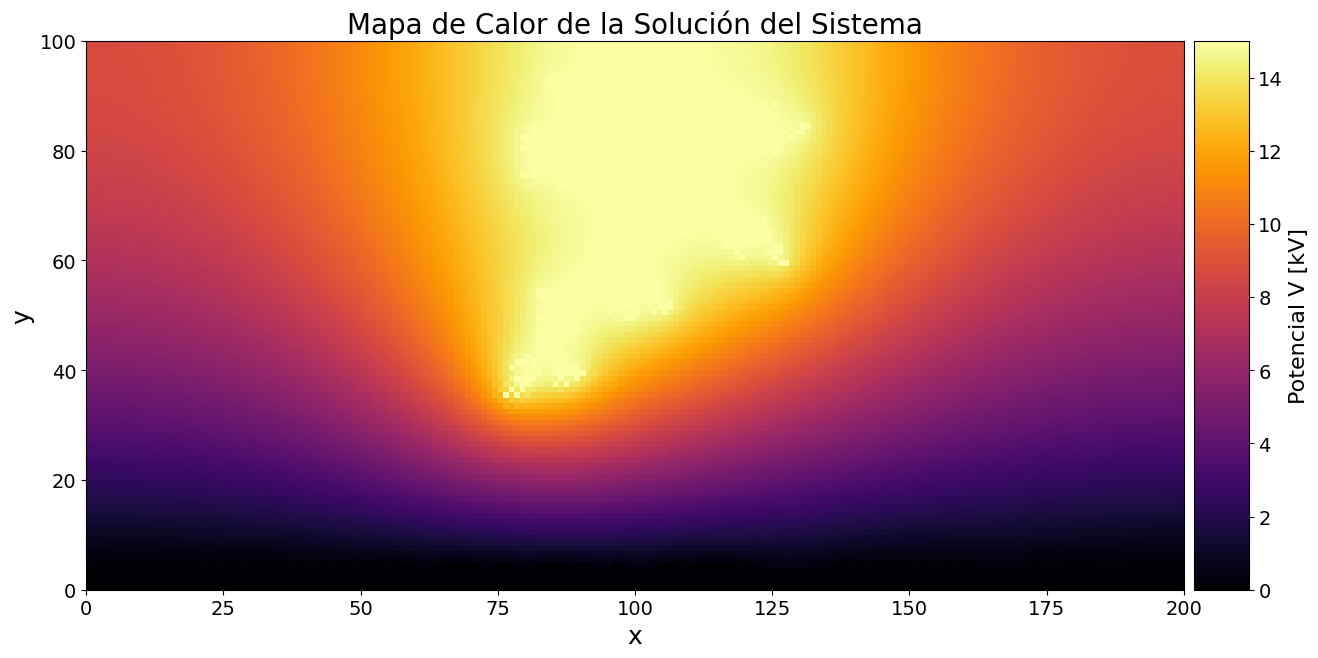

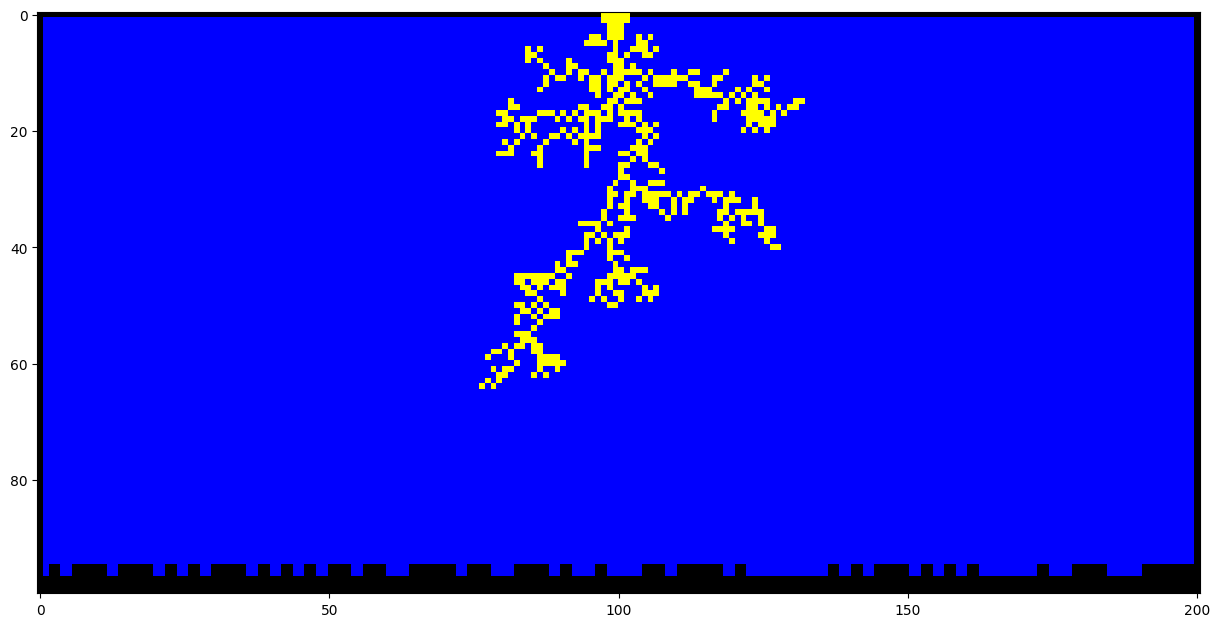

In [7]:
########################################################################################################
########################## Gráfico de resultados #######################################################
########################################################################################################

#mapa de calor de potencia electrico
ux = range(M2.shape[0] + 1)
uy = range(M2.shape[1] + 1)
xx_2d, yy_2d = np.meshgrid(ux, uy, indexing='ij')
fig, ax = plt.subplots(figsize=(15, 12))
pcm = ax.pcolormesh(np.max(uy) - yy_2d, np.max(ux) - xx_2d, V_2d, cmap='inferno')
ax.set_aspect('equal', adjustable='box')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(pcm, cax=cax)
cbar.set_label("Potencial V [kV]", fontsize=16)
ax.set_xlabel("x", fontsize=18)
ax.set_ylabel("y", fontsize=18)
ax.set_title("Mapa de Calor de la Solución del Sistema", fontsize=20)
ax.tick_params(axis='both', labelsize=14)
cbar.ax.tick_params(labelsize=14)
plt.show()

#mapa de geometria
cmap = mcolors.ListedColormap(['black', 'blue', 'green', 'yellow'])
bounds = [-5, 0, 1, 9]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
plt.figure(figsize=(15, 12))
data_volteada = np.fliplr(M2['v'])
plt.imshow(data_volteada, cmap=cmap, norm=norm, interpolation='nearest')
plt.xticks(
    ticks=np.linspace(0, data_volteada.shape[1] - 1, 5),
    labels=np.linspace(0, 200, 5, dtype=int)
)
plt.show()

#agregar un widget para ver como crece dinamicamente el arbol electrico